## Code Modules

In [0]:
import numpy as np,pandas as pd,pylab as pl
import h5py,torch,urllib,zipfile
import tensorflow as tf
from torch.utils.data import DataLoader as tdl
from torch.utils.data import Dataset as tds
import torch.nn.functional as tnnf
from sklearn.datasets import make_classification
from IPython.core.magic import register_line_magic
dev=torch.device("cuda:0" \
if torch.cuda.is_available() else "cpu")

## Data

In [0]:
class tdata(tds):
    def __init__(self,X,y):   
        self.X=torch.tensor(X,dtype=torch.float32)
        self.y=torch.tensor(y,dtype=torch.int32)
    def __getitem__(self,index):
        image,label=self.X[index],self.y[index]
        return image,label
    def __len__(self):
        return self.y.shape[0]
def tloaders(x_train,y_train,x_test,y_test,batch_size):
    train=tdata(x_train,y_train)
    test=tdata(x_test,y_test)
    train_loader=tdl(dataset=train,
                     batch_size=batch_size,shuffle=True)
    test_loader=tdl(dataset=test,
                    batch_size=batch_size,shuffle=False)
    return train_loader,test_loader

In [3]:
(x_train,y_train),(x_test,y_test)=\
tf.keras.datasets.mnist.load_data()
x_train=np.array(x_train,dtype='float32')/255
x_train=x_train.reshape(-1,28,28,1)
x_test=x_test.reshape(-1,28,28,1)
x_test=np.array(x_test,dtype='float32')/255
y_train=np.array(y_train,dtype='int32')
y_test=np.array(y_test,dtype='int32')
x_train.shape,y_train.shape

11493376/11490434 [==============================] - 0s 0us/step


((60000, 28, 28, 1), (60000,))

In [4]:
train_loader,test_loader=\
tloaders(x_train,y_train,x_test,y_test,64)
for images,labels in train_loader:  
    print('Image dimensions: %s'%str(images.shape))
    print('Label dimensions: %s'%str(labels.shape))
    break

Image dimensions: torch.Size([64, 28, 28, 1])
Label dimensions: torch.Size([64])


In [5]:
fpath='https://olgabelitskaya.github.io/'
zf='LetterColorImages_123.h5.zip'
input_file=urllib.request.urlopen(fpath+zf)
output_file=open(zf,'wb'); 
output_file.write(input_file.read())
output_file.close(); input_file.close()
zipf=zipfile.ZipFile(zf,'r')
zipf.extractall(''); zipf.close()
f=h5py.File(zf[:-4],'r')
keys=list(f.keys()); print(keys)
x=np.array(f[keys[1]],dtype='float32')/255
y=np.array(f[keys[2]],dtype='int32')-1
N=len(y); n=int(.2*N)
shuffle_ids=np.arange(N)
np.random.RandomState(23).shuffle(shuffle_ids)
x,y=x[shuffle_ids],y[shuffle_ids]
x_test,x_train=x[:n],x[n:]
y_test,y_train=y[:n],y[n:]
x_train.shape,y_train.shape

['backgrounds', 'images', 'labels']


((11352, 32, 32, 3), (11352,))

In [6]:
train_loader2,test_loader2=\
tloaders(x_train,y_train,x_test,y_test,64)
for images,labels in train_loader2:  
    print('Image dimensions: %s'%str(images.shape))
    print('Label dimensions: %s'%str(labels.shape))
    break

Image dimensions: torch.Size([64, 32, 32, 3])
Label dimensions: torch.Size([64])


## MLP with Sigmoid Activation & MSE Loss

In [0]:
class MLPS():
    def __init__(self,num_features,hidden,num_classes):
        super(MLPS,self).__init__()
        self.num_features=num_features
        self.num_classes=num_classes
        self.weight1=torch.zeros(hidden,num_features, 
                                 dtype=torch.float).normal_(0.,.1)
        self.bias1=torch.zeros(hidden,dtype=torch.float)
        self.weightout=torch.zeros(self.num_classes,hidden, 
                                   dtype=torch.float).normal_(0.,.1)
        self.biasout=torch.zeros(self.num_classes,dtype=torch.float)        
    def forward(self,x):
        z1=torch.mm(x,self.weight1.t())+self.bias1
        a1=torch.sigmoid(z1)
        z2=torch.mm(a1,self.weightout.t())+self.biasout
        a2=torch.sigmoid(z2)
        return a1,a2
    def backward(self,x,a1,a2,y):  
        y_ohe=torch.FloatTensor(y.size(0),self.num_classes)
        y_ohe.zero_()
        y_ohe.scatter_(1,y.view(-1,1).long(),1)
        dloss_da2=2.*(a2-y_ohe)/y.size(0)
        da2_dz2=a2*(1.-a2)
        delta_out=dloss_da2*da2_dz2
        dz2__dw_out=a1
        dloss__dw_out=torch.mm(delta_out.t(),dz2__dw_out)
        dloss__db_out=torch.sum(delta_out,dim=0)
        dz2__a1=self.weightout
        dloss_a1=torch.mm(delta_out,dz2__a1)
        da1__dz1=a1*(1.-a1)
        dz1__dw1=x
        dloss_dw1=torch.mm((dloss_a1*da1__dz1).t(),dz1__dw1)
        dloss_db1=torch.sum((dloss_a1*da1__dz1),dim=0)
        return dloss__dw_out,dloss__db_out,dloss_dw1,dloss_db1

In [0]:
def ohe(y,num_classes):
    y_ohe=torch.FloatTensor(y.size(0),num_classes)
    y_ohe.zero_()
    y_ohe.scatter_(1,y.view(-1,1).long(),1).float()
    return y_ohe
def tloss(targets_ohe,probs_ohe):
    return torch.mean(torch.mean((targets_ohe-probs_ohe)**2,dim=0))
def tmse(model,data_loader):
    curr_mse=torch.zeros(model.num_classes).float()
    num_examples=0
    with torch.no_grad():
        for features,targets in data_loader:
            features=features.view(-1,model.num_features)
            logits,probs=model.forward(features)
            y_ohe=ohe(targets,model.num_classes)
            loss=torch.sum((y_ohe-probs)**2,dim=0)
            num_examples+=targets.size(0)
            curr_mse+=loss
        curr_mse=torch.mean(curr_mse/num_examples,dim=0)
        return curr_mse

In [0]:
def model_train(model,data_loader,num_epochs,learning_rate=.1):
    minibatch_cost=[]; epoch_cost=[]  
    for e in range(num_epochs):
        for batch_idx,(features,targets) in enumerate(data_loader):            
            features=features.view(-1,model.num_features)
            a1,a2=model.forward(features)
            dloss__dw_out,dloss__db_out,dloss_dw1,dloss_db1=\
            model.backward(features,a1,a2,targets)
            model.weight1-=learning_rate*dloss_dw1
            model.bias1-=learning_rate*dloss_db1
            model.weightout-=learning_rate*dloss__dw_out
            model.biasout-=learning_rate*dloss__db_out
            curr_cost=tloss(ohe(targets,model.num_classes),a2)
            minibatch_cost.append(curr_cost)
            if not batch_idx%300:
                print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                       %(e+1,num_epochs,batch_idx,
                         len(data_loader),curr_cost))        
        curr_cost=tmse(model,data_loader)
        epoch_cost.append(curr_cost)
        print('Epoch: %03d/%03d |'%(e+1,num_epochs),end=" ")
        print('Train MSE: %.5f'%curr_cost)
    return minibatch_cost,epoch_cost
def model_acc(model,data_loader):
    correct_pred,num_examples=0,0
    with torch.no_grad():
        for features,targets in data_loader:
            features=features.view(-1,model.num_features)
            _,outputs=model.forward(features)
            predicted_labels=torch.argmax(outputs,1)
            num_examples+=targets.size(0)
            correct_pred+=(predicted_labels==targets).sum()
        return correct_pred.float()/num_examples*100 

## Model 1

In [10]:
torch.manual_seed(23)
model=MLPS(num_features=28*28*1,
           hidden=128,num_classes=10)
minibatch_cost,epoch_cost=\
model_train(model,train_loader,
            num_epochs=100,learning_rate=.07)

Epoch: 001/100 | Batch 000/938 | Cost: 0.2663
Epoch: 001/100 | Batch 300/938 | Cost: 0.0718
Epoch: 001/100 | Batch 600/938 | Cost: 0.0535
Epoch: 001/100 | Batch 900/938 | Cost: 0.0558
Epoch: 001/100 | Train MSE: 0.04497
Epoch: 002/100 | Batch 000/938 | Cost: 0.0441
Epoch: 002/100 | Batch 300/938 | Cost: 0.0367
Epoch: 002/100 | Batch 600/938 | Cost: 0.0338
Epoch: 002/100 | Batch 900/938 | Cost: 0.0355
Epoch: 002/100 | Train MSE: 0.03112
Epoch: 003/100 | Batch 000/938 | Cost: 0.0309
Epoch: 003/100 | Batch 300/938 | Cost: 0.0328
Epoch: 003/100 | Batch 600/938 | Cost: 0.0242
Epoch: 003/100 | Batch 900/938 | Cost: 0.0308
Epoch: 003/100 | Train MSE: 0.02578
Epoch: 004/100 | Batch 000/938 | Cost: 0.0273
Epoch: 004/100 | Batch 300/938 | Cost: 0.0205
Epoch: 004/100 | Batch 600/938 | Cost: 0.0301
Epoch: 004/100 | Batch 900/938 | Cost: 0.0309
Epoch: 004/100 | Train MSE: 0.02291
Epoch: 005/100 | Batch 000/938 | Cost: 0.0261
Epoch: 005/100 | Batch 300/938 | Cost: 0.0200
Epoch: 005/100 | Batch 600/9

In [11]:
print('Training Accuracy: %.2f'%model_acc(model,train_loader))
print('Test Accuracy: %.2f'%model_acc(model,test_loader))

Training Accuracy: 96.93
Test Accuracy: 96.34


Predicted labels:  tensor([1, 4, 9, 6, 9])


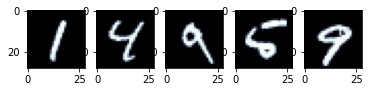

In [12]:
for features,targets in test_loader: break
fig,ax=pl.subplots(1,5)
for i in range(5):
    ax[i].imshow(features[5+i].view(28,28),
                 cmap=pl.cm.bone)
_,predictions=\
model.forward(features[5:10].view(-1,model.num_features))
pred_labels=torch.argmax(predictions,dim=1)
print('Predicted labels: ',pred_labels)

## Model 2

In [14]:
torch.manual_seed(23)
model=MLPS(num_features=32*32*3,
           hidden=512,num_classes=33)
minibatch_cost2,epoch_cost2=\
model_train(model,train_loader2,
            num_epochs=400,learning_rate=.1)

Epoch: 001/400 | Batch 000/178 | Cost: 0.3685
Epoch: 001/400 | Train MSE: 0.02970
Epoch: 002/400 | Batch 000/178 | Cost: 0.0297
Epoch: 002/400 | Train MSE: 0.02958
Epoch: 003/400 | Batch 000/178 | Cost: 0.0297
Epoch: 003/400 | Train MSE: 0.02950
Epoch: 004/400 | Batch 000/178 | Cost: 0.0294
Epoch: 004/400 | Train MSE: 0.02943
Epoch: 005/400 | Batch 000/178 | Cost: 0.0294
Epoch: 005/400 | Train MSE: 0.02937
Epoch: 006/400 | Batch 000/178 | Cost: 0.0295
Epoch: 006/400 | Train MSE: 0.02932
Epoch: 007/400 | Batch 000/178 | Cost: 0.0294
Epoch: 007/400 | Train MSE: 0.02929
Epoch: 008/400 | Batch 000/178 | Cost: 0.0294
Epoch: 008/400 | Train MSE: 0.02927
Epoch: 009/400 | Batch 000/178 | Cost: 0.0293
Epoch: 009/400 | Train MSE: 0.02925
Epoch: 010/400 | Batch 000/178 | Cost: 0.0293
Epoch: 010/400 | Train MSE: 0.02923
Epoch: 011/400 | Batch 000/178 | Cost: 0.0294
Epoch: 011/400 | Train MSE: 0.02923
Epoch: 012/400 | Batch 000/178 | Cost: 0.0292
Epoch: 012/400 | Train MSE: 0.02920
Epoch: 013/400 |

In [15]:
print('Training Accuracy: %.2f'%model_acc(model,train_loader2))
print('Test Accuracy: %.2f'%model_acc(model,test_loader2))

Training Accuracy: 47.03
Test Accuracy: 43.09
